# Import libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [26]:
#Plot the Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('importances-01.png')
    plt.show()
    sns.set()

# Read the training and testing data


In [72]:
train_df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv")

# Add Temporal Features

In [73]:
train_df = train_df.sort_values('date').reset_index(drop=True) 
test_df = test_df.sort_values('date').reset_index(drop=True)

train_df['date'] = train_df['date'].astype('datetime64[ns]')
test_df['date'] = test_df['date'].astype('datetime64[ns]')

for dataset in (train_df,test_df):
    dataset['date_Int'] = dataset['date'].astype(np.int64) * 1e-9
    dataset['Day'] = dataset.date.dt.day
    dataset['Month'] = dataset.date.dt.month
    dataset['Year'] = dataset.date.dt.year         
    dataset['DayOfWeek'] = dataset.date.dt.dayofweek
    dataset['DayOfYear'] = dataset.date.dt.dayofyear
    dataset['WeekOfYear'] = dataset.date.dt.weekofyear
    dataset['Quarter'] = dataset.date.dt.quarter
    dataset.set_index('date', inplace=True)

C:\Users\moham\AppData\Local\Temp\ipykernel_14748\348444444.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

  dataset['WeekOfYear'] = dataset.date.dt.weekofyear

C:\Users\moham\AppData\Local\Temp\ipykernel_14748\348444444.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

  dataset['WeekOfYear'] = dataset.date.dt.weekofyear


# Exploratory data analysis

In [5]:
train_df.shape

(1462, 12)

In [6]:
test_df.shape

(114, 12)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01

Data columns (total 12 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   meantemp      1462 non-null   float64

 1   humidity      1462 non-null   float64

 2   wind_speed    1462 non-null   float64

 3   meanpressure  1462 non-null   float64

 4   date_Int      1462 non-null   float64

 5   Day           1462 non-null   int64  

 6   Month         1462 non-null   int64  

 7   Year          1462 non-null   int64  

 8   DayOfWeek     1462 non-null   int64  

 9   DayOfYear     1462 non-null   int64  

 10  WeekOfYear    1462 non-null   int64  

 11  Quarter       1462 non-null   int64  

dtypes: float64(5), int64(7)

memory usage: 148.5 KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24

Data columns (total 12 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   meantemp      114 non-null    float64

 1   humidity      114 non-null    float64

 2   wind_speed    114 non-null    float64

 3   meanpressure  114 non-null    float64

 4   date_Int      114 non-null    float64

 5   Day           114 non-null    int64  

 6   Month         114 non-null    int64  

 7   Year          114 non-null    int64  

 8   DayOfWeek     114 non-null    int64  

 9   DayOfYear     114 non-null    int64  

 10  WeekOfYear    114 non-null    int64  

 11  Quarter       114 non-null    int64  

dtypes: float64(5), int64(7)

memory usage: 11.6 KB


In [9]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure,date_Int,Day,Month,Year,DayOfWeek,DayOfYear,WeekOfYear,Quarter
date,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1.356998e+09,1,1,2013,1,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,1.357085e+09,2,1,2013,2,2,1,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,1.357171e+09,3,1,2013,3,3,1,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1.357258e+09,4,1,2013,4,4,1,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,1.357344e+09,5,1,2013,5,5,1,1


In [10]:
test_df.head()

,meantemp,humidity,wind_speed,meanpressure,date_Int,Day,Month,Year,DayOfWeek,DayOfYear,WeekOfYear,Quarter
date,,,,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,1.483229e+09,1,1,2017,6,1,52,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,1.483315e+09,2,1,2017,0,2,1,1
2017-01-03,17.111111,81.888889,4.016667,1018.333333,1.483402e+09,3,1,2017,1,3,1,1
2017-01-04,18.700000,70.050000,4.545000,1015.700000,1.483488e+09,4,1,2017,2,4,1,1
2017-01-05,18.388889,74.944444,3.300000,1014.333333,1.483574e+09,5,1,2017,3,5,1,1


In [11]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure,date_Int,Day,Month,Year,DayOfWeek,DayOfYear,WeekOfYear,Quarter
count,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548,1.420114e+09,15.719562,6.519152,2014.502736,3.002052,183.000684,26.644323,2.507524
std,7.348103,16.769652,4.561602,180.231668,3.647699e+07,8.808520,3.451727,1.120248,1.999828,105.546176,15.079054,1.117779
min,6.000000,13.428571,0.000000,-3.041667,1.356998e+09,1.000000,1.000000,2013.000000,0.000000,1.000000,1.000000,1.000000
25%,18.857143,50.375000,3.475000,1001.580357,1.388556e+09,8.000000,4.000000,2014.000000,1.000000,92.000000,14.000000,2.000000
50%,27.714286,62.625000,6.221667,1008.563492,1.420114e+09,16.000000,7.000000,2015.000000,3.000000,183.000000,27.000000,3.000000
75%,31.305804,72.218750,9.238235,1014.944901,1.451671e+09,23.000000,10.000000,2016.000000,5.000000,274.000000,40.000000,4.000000
max,38.714286,100.000000,42.220000,7679.333333,1.483229e+09,31.000000,12.000000,2017.000000,6.000000,366.000000,53.000000,4.000000


In [12]:
test_df.describe()  

,meantemp,humidity,wind_speed,meanpressure,date_Int,Day,Month,Year,DayOfWeek,DayOfYear,WeekOfYear,Quarter
count,114.000000,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000,114.0,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090,1.488110e+09,14.894737,2.421053,2017.0,3.000000,57.500000,8.956140,1.210526
std,6.360072,19.068083,3.588049,89.474692,2.855778e+06,8.495046,1.104254,0.0,2.030737,33.052988,6.183607,0.409482
min,11.000000,17.750000,1.387500,59.000000,1.483229e+09,1.000000,1.000000,2017.0,0.000000,1.000000,1.000000,1.000000
25%,16.437198,39.625000,5.563542,1007.437500,1.485670e+09,8.000000,1.000000,2017.0,1.000000,29.250000,5.000000,1.000000
50%,19.875000,57.750000,8.069444,1012.739316,1.488110e+09,15.000000,2.000000,2017.0,3.000000,57.500000,9.000000,1.000000
75%,27.705357,71.902778,10.068750,1016.739583,1.490551e+09,22.000000,3.000000,2017.0,5.000000,85.750000,13.000000,1.000000
max,34.500000,95.833333,19.314286,1022.809524,1.492992e+09,31.000000,4.000000,2017.0,6.000000,114.000000,52.000000,2.000000


# Plots


<AxesSubplot:xlabel='meantemp', ylabel='Count'>

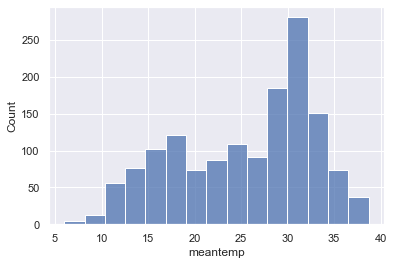

In [13]:
#Target Histogram
sns.set()
sns.histplot(train_df['meantemp'])

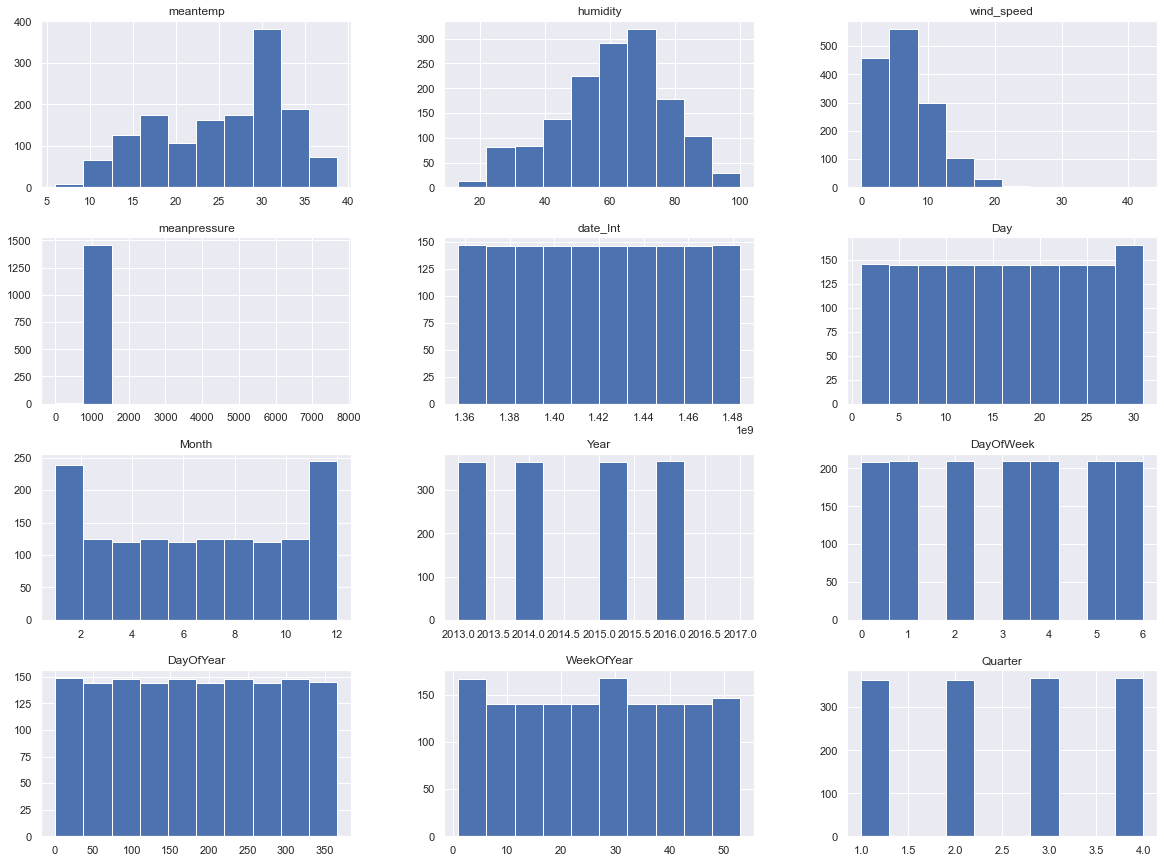

In [14]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

# Feature Engineering

## Lags Features For Features Other Than The Target

In [74]:
feats = ['wind_speed']
for dataset in (train_df,test_df):
    for feat in feats:
        for window in [1,365,730]:
            dataset[f'{feat}_Diff_{window}'] = dataset[feat].diff(window)

## Lags For Target

In [75]:
df = pd.concat([train_df,test_df])
feat = 'meantemp'
for window in [365,730,1095]:
    df[f'{feat}_Lag_{window}'] = df[feat].shift(window)
    df[f'{feat}_Dif_{window}'] = df[feat].diff(window)

train_df = df[:train_df.shape[0]]
test_df = df[train_df.shape[0]:]

## Combination Between Time Features

In [76]:
for dataset in (train_df,test_df):
        dataset.loc[:,'Month_Day'] = dataset.loc[:,'Month'].astype(str) + '-' + dataset.loc[:,'Day'].astype(str)
#Label Encode Them
feats = ['Month_Day']

le = LabelEncoder()
df = pd.concat([train_df,test_df])

for feat in feats:
    le.fit(df[feat])
    train_df.loc[:,feat] = le.transform(train_df.loc[:,feat])
    test_df.loc[:,feat] = le.transform(test_df.loc[:,feat])

C:\Users\moham\AppData\Local\Temp\ipykernel_14748\273696839.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset.loc[:,'Month_Day'] = dataset.loc[:,'Month'].astype(str) + '-' + dataset.loc[:,'Day'].astype(str)

C:\Users\moham\AppData\Local\Temp\ipykernel_14748\273696839.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset.loc[:,'Month_Day'] = dataset.loc[:,'Month'].astype(str) + '-' + dataset.loc[:,'Day'].astype(str)


## Add Aggregations Based on Time WITH Target

In [77]:
def Agg(Feature):
    for dataset in (train_df,test_df):
        for feat_1 in ['Year','Month','WeekOfYear','Day']:
            dataset[f'{Feature}_Agg_{feat_1}_mean'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].mean()))
            dataset[f'{Feature}_Agg_{feat_1}_median'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].median()))
            dataset[f'{Feature}_Agg_{feat_1}_std'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].std()))
            dataset[f'{Feature}_Agg_{feat_1}_min'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].min()))
            dataset[f'{Feature}_Agg_{feat_1}_max'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].max()))
            dataset[f'{Feature}_Agg_{feat_1}_sum'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].sum()))
            dataset[f'{Feature}_Agg_{feat_1}_range'] = dataset[f'{Feature}_Agg_{feat_1}_max'] - dataset[f'{Feature}_Agg_{feat_1}_min']
            dataset[f'{Feature}_Agg_{feat_1}_var'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].var()))
            dataset[f'{Feature}_Agg_{feat_1}_skew'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].skew()))
            for n in [0.10,0.25,0.75,0.90]:
                dataset[f'{Feature}_Agg_{feat_1}_quantile_{n}'] = dataset[feat_1].map(dict(train_df.groupby(feat_1)[Feature].quantile(n)))        
feats = ['meantemp']
for feat in feats:         
    Agg(feat)

## Dropping Duplicates and Constants Features

In [78]:
print('Features Before Dropping: ', train_df.shape)
cols = train_df.columns
dup = []
for feat_1 in tqdm(cols):
    if (feat_1 in dup):
        continue
    for feat_2 in cols.drop(feat_1):
        if (feat_2 in dup):
            continue
        if (train_df[feat_1].equals(train_df[feat_2])):
            train_df.drop(feat_2,inplace=True,axis=1)
            test_df.drop(feat_2,inplace=True,axis=1)
            dup.append(feat_2)
            
for feat in tqdm(test_df.columns):
    if ((len(train_df[feat].value_counts().keys()) == 1) | (len(test_df[feat].value_counts().keys()) == 1)):
        train_df.drop(feat,inplace=True,axis=1)
        test_df.drop(feat,inplace=True,axis=1)
print('Features After Dropping: ', train_df.shape)

Features Before Dropping:  (1462, 74)


100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 1279.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 2961.06it/s]

Features After Dropping:  (1462, 63)


# Modeling

In [79]:
lgbm = LGBMRegressor(max_depth=6, random_state=42)

## Validation:

In [80]:
print('Validating...')

X = train_df.drop('meantemp',axis=1).values
y = train_df['meantemp'].values


scores = []
for train_index, test_index in TimeSeriesSplit(n_splits=4).split(X, y):
    X_Train, X_Test = X[train_index], X[test_index]
    y_Train, y_Test = y[train_index], y[test_index]
    lgbm.fit(X_Train,y_Train)
    y_pred = lgbm.predict(X_Test)
    scores.append(mean_absolute_error(y_Test,y_pred))
    print(scores[-1])
    
print("\nMean:",np.mean(scores),"\nSTD: ", np.std(scores))

Validating...

4.226725047750653

1.2447177152811761

1.2085141227783671

1.140226620383686



Mean: 1.9550458765484706 

STD:  1.3120911204225882


## Show the Features Importances 

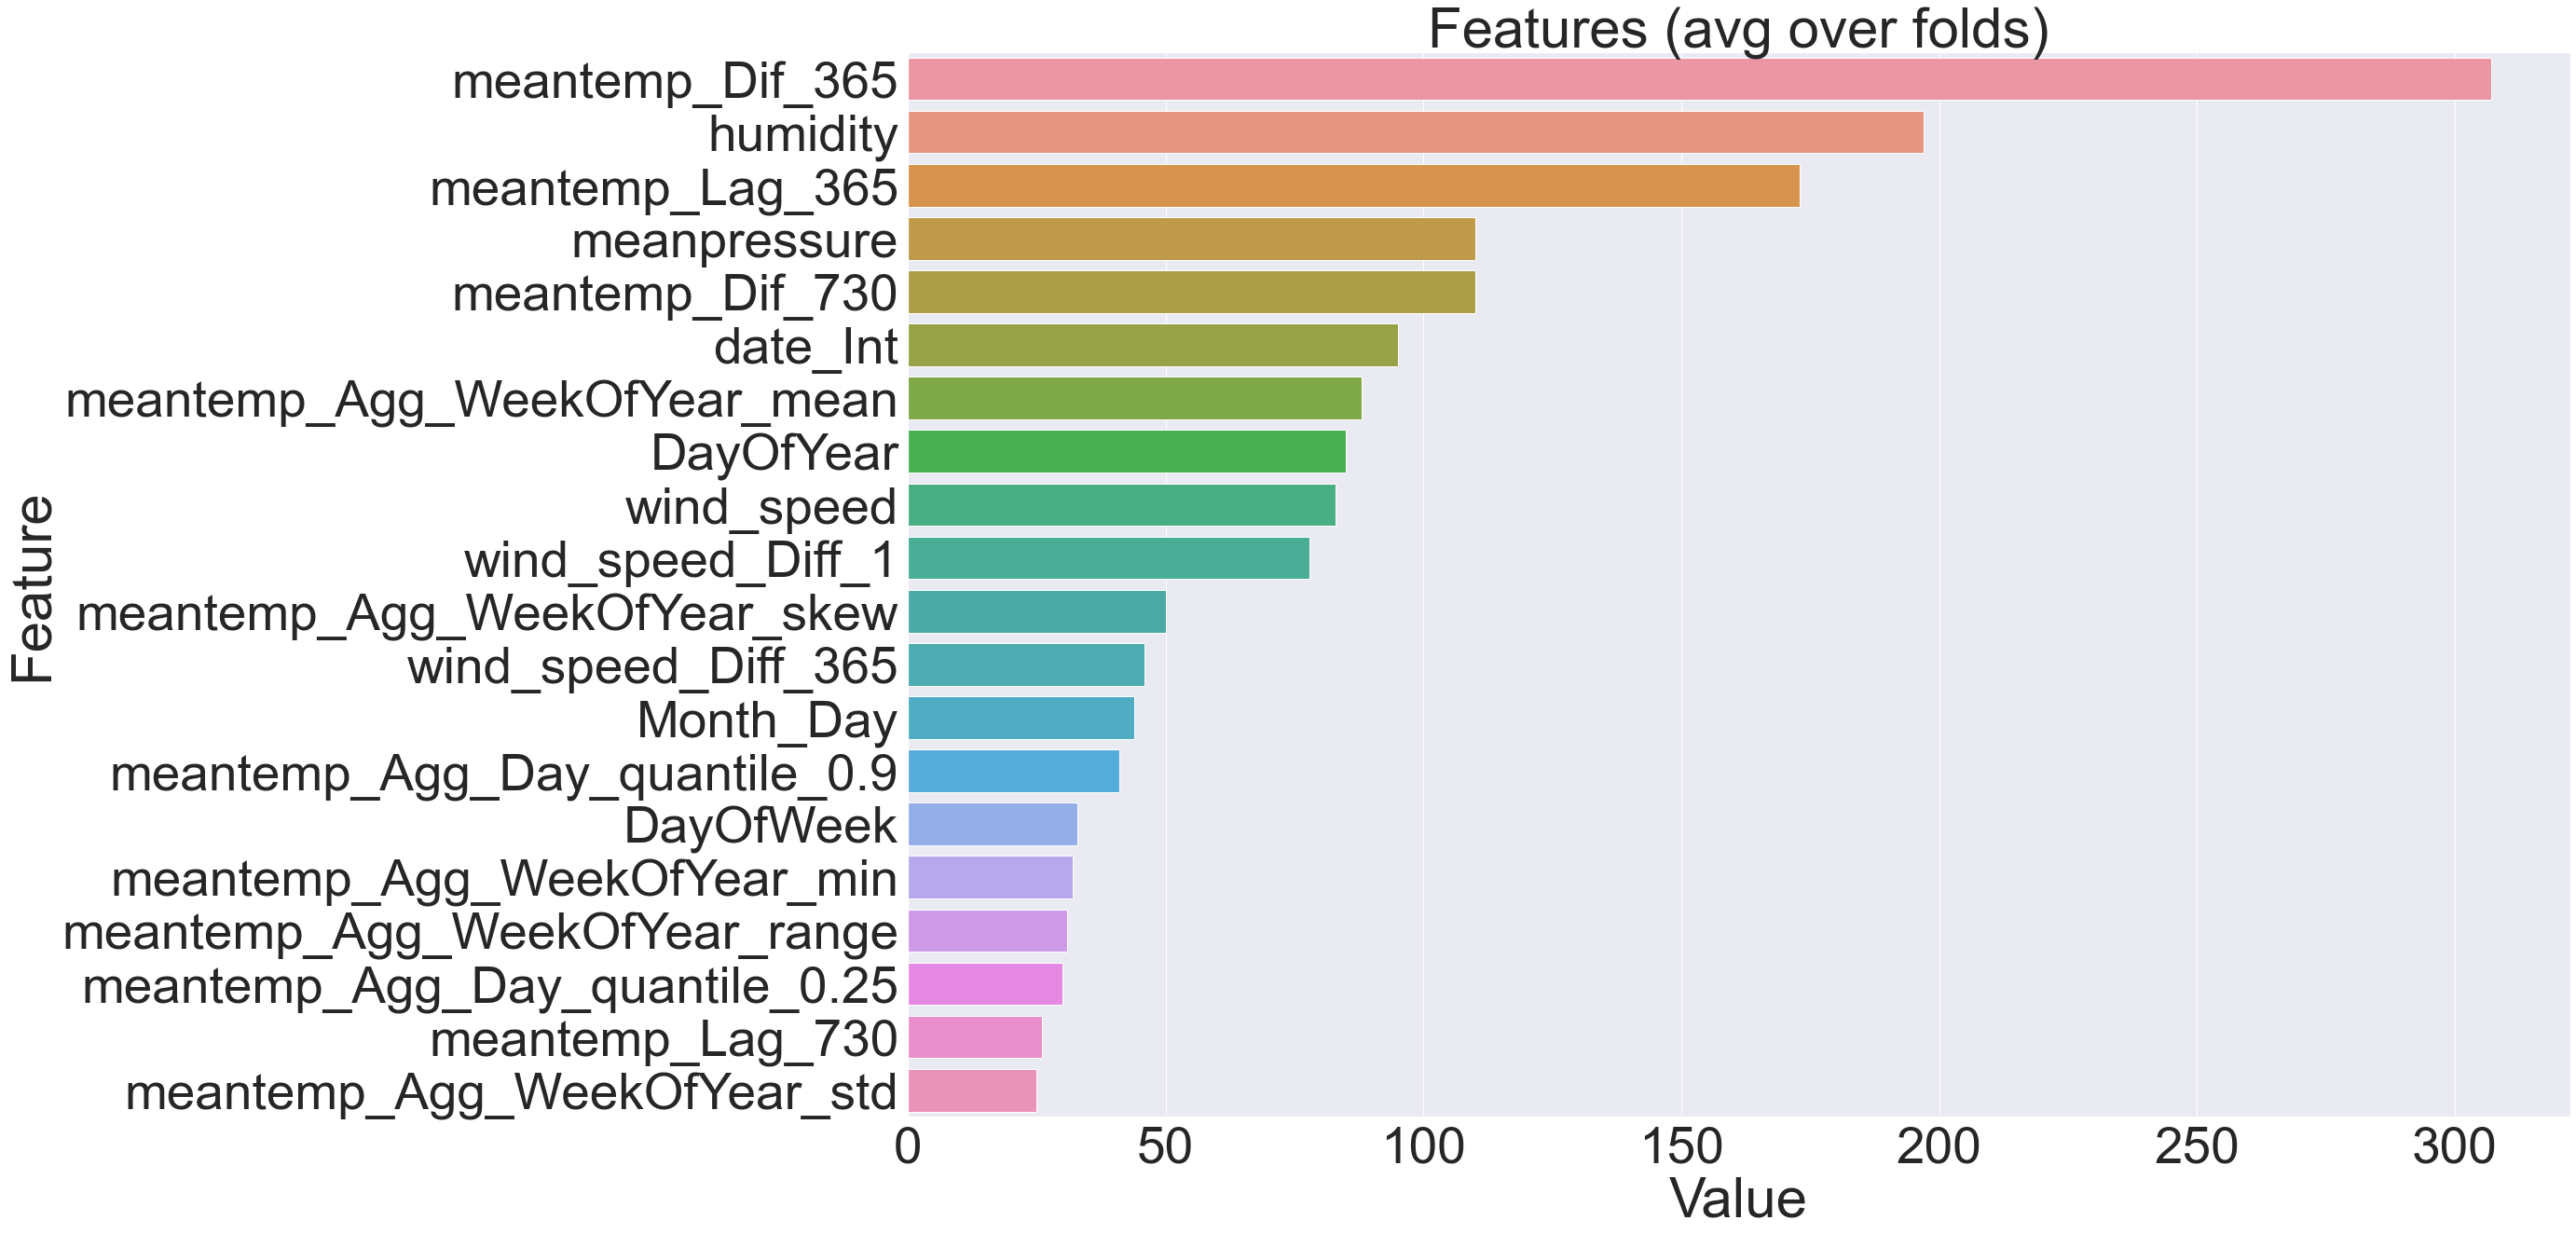

In [81]:
plotImp(lgbm,train_df.drop('meantemp',axis=1))

## Evaluating on the Test Set

In [82]:
from sklearn.metrics import mean_absolute_error
X = train_df.drop('meantemp',axis=1)
y = train_df['meantemp']

lgbm.fit(X,y)
Predictions = lgbm.predict(test_df.drop('meantemp',axis=1))

print("Mean Absolute Error: ", mean_absolute_error(test_df['meantemp'].values,Predictions))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test_df['meantemp'].values,Predictions))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(test_df['meantemp'].values,Predictions)))

Mean Absolute Error:  1.015276851016731

Mean Absolute Percentage Error:  0.05005183112350709

Root Mean Squared Error:  1.2800527299927331


# Plot The Results

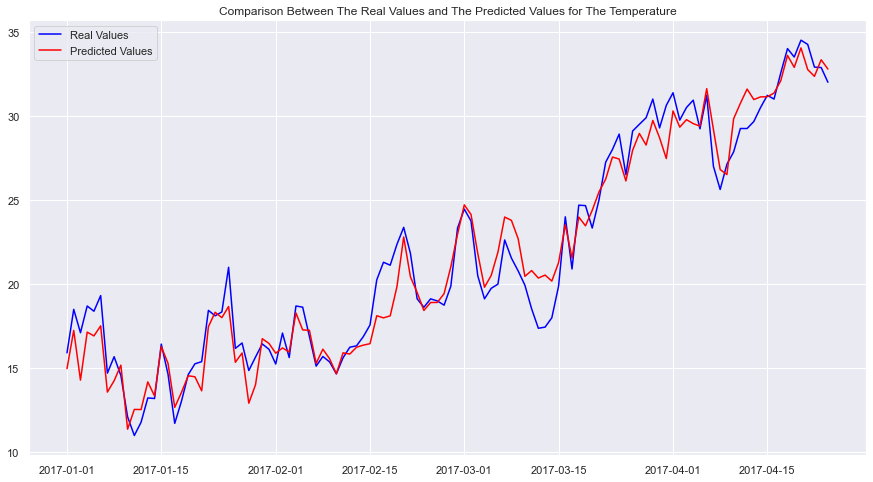

In [83]:
fig = plt.figure(figsize=(15,8))
plt.plot(test_df.index,test_df.meantemp,label='Real Values',color='blue')
plt.plot(test_df.index,Predictions,label='Predicted Values',color = "red")
plt.title('Comparison Between The Real Values and The Predicted Values for The Temperature')
plt.legend()
plt.show()